# Best Practices - PyTorch YOLOv7 on PASCAL VOC

## Optimizing YOLOv7 with NetsPresso Model Compressor
By following this notebook, the user can get YOLOv7 which has ?x low latency, ?x fewer parameters only with ? drop by using NetsPresso Model Compressor.


This notebook contains the following 5 parts:
  1. [Model Compression with NetsPresso Model Compressor](#1.-Model-Compression-with-NetsPresso-Model-Compressor)
  2. [Fine-Tuning the Compressed Model](#2.-Fine-tuning-the-Compressed-Model)
  3. [Compression Results](#3.-Compression-Results)
  4. [Appendix 1. Transfer Learning on PASCAL VOC](#Appendix-1.-Transfer-Learning-on-PASCAL-VOC)
  5. [Appendix 2. Description of The Modifications](#Appendix-2.-Description-of-The-Modifications)
  
For more details about NetsPresso Model Compressor, please visit [Docs](https://docs.netspresso.ai/docs/technology-support-1) and [Netspresso.ai](https://www.netspresso.ai).


<div align="center">

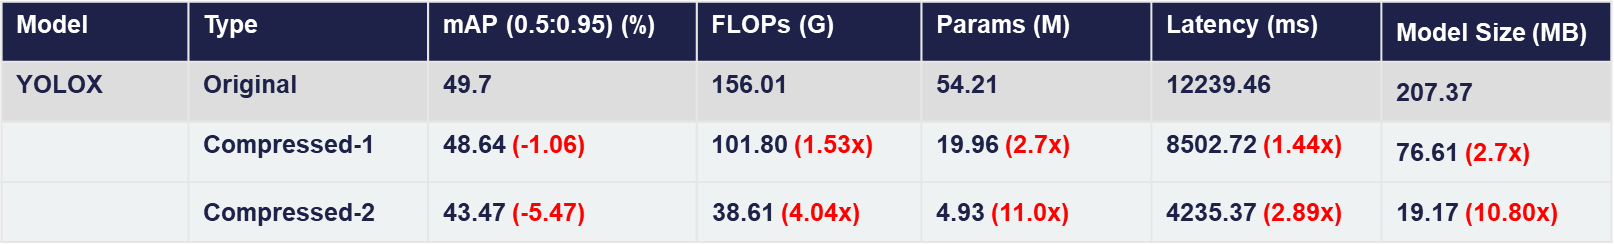
</div>
<div align='center'>
Fig. 1 Compression results of the YOLOv7. The model's latency is measured using a Raspberry Pi 4B (1.5GHz ARM Cortex). We set the model's data type to FP32, and an inference engine to ONNX Runtime to measure the latency.
</div>


<a name="1.-Model-Compression-with-NetsPresso-Model-Compressor"></a>
# 1. Model Compression with NetsPresso Model Compressor

### Setting up your environment


Cloning the YOLOV7 code ([link](https://github.com/WongKinYiu/yolov7))

In [1]:
! git clone  https://github.com/WongKinYiu/yolov7.git

Cloning into 'yolov7'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1100 (delta 1), reused 1 (delta 0), pack-reused 1094
Receiving objects: 100% (1100/1100), 69.91 MiB | 21.56 MiB/s, done.
Resolving deltas: 100% (509/509), done.


Please make sure your current directory is `yolov7`.

In [2]:
import os
os.chdir('yolov7')

! pwd

Installing the following packages:

In [4]:
! pip install -r requirements.txt
! pip install onnx
! pip install thop
! pip install torchinfo
! pip install torchsummary
! apt-get install -y libgl1-mesa-glx
# You MUST install the compatible torch version with your cuda version. Here, we set PyTorch 1.13.1 with CUDA 11.6 as default. (Support: PyTorch version >= 1.10) 
! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
! pip install numpy==1.22.0

  Using cached matplotlib-3.6.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.3 MB/s eta 0:00:0000:0100:01
  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)
  Using cached Pillow-9.3.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Using cached PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached scipy-1.9.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (33.8 MB)
  Using cached torch-1.13.1-cp38-cp38-manylinux1_x86_64.whl (887.4 MB)
  Using cached torchvision-0.14.1-cp38-cp38-manylinux1_x86_64.whl (24.2 MB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached protobuf-4.21.2-cp37-abi3-manylinux2014_x86_64.whl (407 kB)
  Using cached tensorboard-2.11.0-py3-none-any.whl (6

### Preparing the pretrained model

You can get the PASCAL VOC pretrained YOLOv7 (GraphModule format) `yolov7_voc.pt` by running the following code block. The model will be downloaded in the directory `yolov7`.
* Or you can train YOLOv7 model on PASCAL VOC in [Appendix 1](#Appendix-1.-Transfer-Learning-on-PASCAL-VOC).

In [8]:
! wget https://netspresso-compression-toolkit-public.s3.ap-northeast-2.amazonaws.com/model_zoo/torch/pascal_voc/pretrained/yolov7_voc.pt

--2022-12-28 01:47:14--  https://netspresso-compression-toolkit-public.s3.ap-northeast-2.amazonaws.com/model_zoo/torch/pascal_voc/pretrained/yolov7_voc.pt
Resolving netspresso-compression-toolkit-public.s3.ap-northeast-2.amazonaws.com (netspresso-compression-toolkit-public.s3.ap-northeast-2.amazonaws.com)... 52.219.56.51
Connecting to netspresso-compression-toolkit-public.s3.ap-northeast-2.amazonaws.com (netspresso-compression-toolkit-public.s3.ap-northeast-2.amazonaws.com)|52.219.56.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149664067 (143M) [application/x-www-form-urlencoded]
Saving to: ‘yolov7_voc.pt’

yolov7_voc.pt       100%[===================>] 142.73M  38.3MB/s    in 3.6s    

2022-12-28 01:47:18 (39.2 MB/s) - ‘yolov7_voc.pt’ saved [149664067/149664067]



### **YOLOv7 compression using NetsPresso Model Compressor**

<a name='compGuide'></a>

__Compression Guide__ 
1. Sign up for NetsPresso Model Compressor ([link](https://compression.netspresso.ai/#/login)).
2. Upload the original YOLOv7 `yolov7_voc.pt`. The model format should be `GraphModule (torch.fx.GraphModule)`.
3. To reproduce the best practice result, please select the following compression procedures one by one as depicted [here](#2.-Fine-tuning-the-Compressed-Model): 
    * `L2 Norm Pruning` &rarr; `Recommendation(SLAMP) pruning ratio: 0.2`
        
4. Press `Compress` button, and get the compressed model. The compression result will be shown as follow.

<div align='center'>
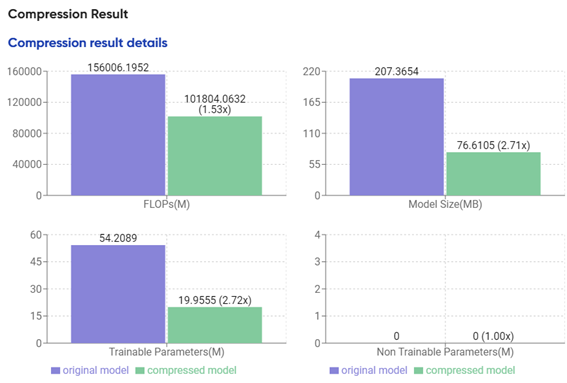
&nbsp; &nbsp; &nbsp; &nbsp;
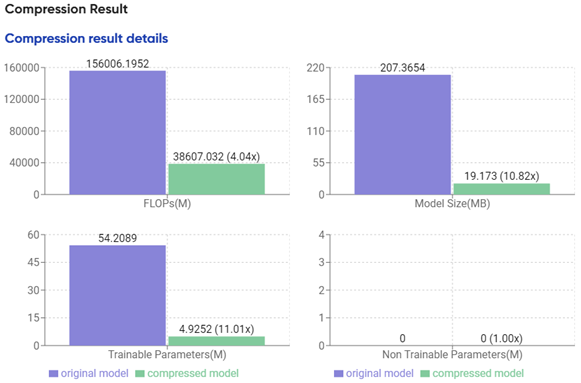
</div>
<div align='center'>
Fig 2. The results of each compression. Left: L2 Norm Pruning (0.4). Right: L2 Norm Pruning (0.7).
</div>

<a name="2.-Fine-tuning-the-Compressed-Model"></a>
# 2. Fine-tuning the Compressed Model
Structure pruning may induce the performance degradation, which requires additional fine-tuning process.  
Therefore, the fine-tuning process is necessary to compensate the performance after each compression process.  
Here, `L2 Norm Pruning` &rarr; `Fine-tuning`

### Preparing PASCAL VOC dataset

In [19]:
# Download VOC dataset
! wget voc.sh
! sh voc.sh

# Convert VOC as YOLO format
! wget https://raw.githubusercontent.com/yjlee0607/yolov7_files/main/VOC_to_YOLO_format.py
! python VOC_to_YOLO_format.py

test2007: 100%|███████████████████████████| 4952/4952 [00:01<00:00, 3257.05it/s]


<a name='#-Preparing-YAML-files-for-fine-tuning-the-model-on-PASCAL-VOC'></a>
### Preparing YAML files for fine-tuning the model on PASCAL VOC

In [20]:
# Downloading a PASCAL VOC yolov7 trainig model config file
! cd cfg/training && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolov7_voc/yolov7-voc.yaml

# Downloading a PASCAL VOC data config file
! cd data && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolov7_voc/voc.yaml

# Downloading a PASCAL VOC YOLOv7 training hyper-parameter config file
! cd data && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolov7_voc/hyp.scratch.p5-voc.yaml

--2022-12-28 02:06:08--  https://raw.githubusercontent.com/yjlee0607/yolov7_files/main/yolov7-voc.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3999 (3.9K) [text/plain]
Saving to: ‘yolov7-voc.yaml’

yolov7-voc.yaml     100%[===================>]   3.91K  --.-KB/s    in 0s      

2022-12-28 02:06:08 (45.6 MB/s) - ‘yolov7-voc.yaml’ saved [3999/3999]

--2022-12-28 02:06:08--  https://raw.githubusercontent.com/yjlee0607/yolov7_files/main/voc.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 741 [text/plain]
Saving to: ‘voc.y

<a name='#fine-tuning'></a>
### Fine-tuning the compressed model

To fine-tune the compressed model, we need to modify some codes in `train.py` and `test.py`. You can get the modified codes `train_npmc.py` and `test_npmc.py` by running the following code block. You can see the details of the modifications at [Appendix 1](#Appendix).

In [26]:
! wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolov7_voc/train_npmc.py
! wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolov7_voc/test_npmc.py
! cd models && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolov7_voc/experimental_npmc.py && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolov7_voc/yolo_npmc.py

--2022-12-28 02:13:59--  https://raw.githubusercontent.com/yjlee0607/yolov7_files/main/experimental_npmc.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14705 (14K) [text/plain]
Saving to: ‘experimental_npmc.py.1’

experimental_npmc.p 100%[===================>]  14.36K  --.-KB/s    in 0s      

2022-12-28 02:13:59 (30.6 MB/s) - ‘experimental_npmc.py.1’ saved [14705/14705]

--2022-12-28 02:13:59--  https://raw.githubusercontent.com/yjlee0607/yolov7_files/main/yolo_npmc.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54906 (54

In this notebook, we fine-tune ([link](#2.-Fine-tuning-the-Compressed-Model)) and verify ([link](#3.-Compression-Results)) the model for the best practice case of Fig. 1 by default.  
* `yolov7_voc_compressed_model_L2Norm_02.pt` means the model compressed by `L2 Norm Pruning (pruning ratio: 0.2)`.

In [33]:
! python train_npmc.py \
--workers 8 \
--device 0 \
--batch-size 16 \
--data data/voc.yaml \
--img-size 640 640 \
--cfg cfg/training/yolov7-voc.yaml \
--weights yolov7.pt \
--name yolov7_voc_compressed_model_L2Norm_02 \
--hyp data/hyp.scratch.p5-voc.yaml \
--graphmodule yolov7_voc_compressed_model_L2Norm_02.pt \
--epochs 300

/opt/conda/envs/yolov7_bp/lib/python3.8/site-packages/torch/distributed/launch.py:180: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
YOLOR 🚀 v0.1-117-g8e9f0b7 torch 1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24268.3125MB)
                                             CUDA:1 (NVIDIA GeForce RTX 3090, 24268.3125MB)
                                     

In [ ]:
! python -m torch.distributed.launch --nproc_per_node 4 --master_port 9990 train_npmc.py --workers 8 --device 0,1,2,3 \
--sync-bn --batch-size 16 \
--data ./data/voc.yaml \
--img-size 640 640 \
--cfg ./cfg/training/yolov7-voc.yaml \
--weights yolov7.pt \
--name yolov7_voc_compressed_model_L2Norm_02 \
--hyp ./data/hyp.scratch.p5-voc.yaml \
--graphmodule yolov7_voc_compressed_model_L2Norm_02.pt \
--epochs 100

### Reparameterization

YOLOv7 includes `RepConv` and `Implicit knowledge` layers of which structures are changed at inference time. To reparameterization GraphModule format YOLOv7, please download `reparameterization_npmc.py` and run the following code.

In [34]:
! wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolov7_voc/reparameterization_npmc.py

--2022-12-28 02:23:01--  https://raw.githubusercontent.com/yjlee0607/yolov7_files/main/reparameterization_nptk.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7889 (7.7K) [text/plain]
Saving to: ‘reparameterization_nptk.py’

reparameterization_ 100%[===================>]   7.70K  --.-KB/s    in 0s      

2022-12-28 02:23:02 (35.2 MB/s) - ‘reparameterization_nptk.py’ saved [7889/7889]



In [36]:
!python reparameterization_npmc.py \
--model runs/train/yolov7_voc_compressed_model_L2Norm_02/weights/best.pt \
--save_model_path yolov7_voc_compressed_model_L2Norm_02_rep.pt

Fusing Conv-BN
Fusing Conv-BN - Success
Reparameterizing
Traceback (most recent call last):
  File "reparameterization_nptk.py", line 190, in <module>
    fused_model = fusing_yolov7(model)
  File "reparameterization_nptk.py", line 134, in fusing_yolov7
    rep_conv1x1(fused_model,head,conv1x1,conv3x3,tail)
  File "reparameterization_nptk.py", line 76, in rep_conv1x1
    head.users = {conv3x3:None}
AttributeError: 'NoneType' object has no attribute 'users'


<a name="3.-Compression-Results"></a>
# 3. Compression Results

In this section, we visualize and verify the effectiveness of the NetsPresso Model Compressor on YOLOv7.

* [Visualizing the optimization process on YOLOv7](#Visualizing-the-optimization-process-on-YOLOv7)
* [Architecture of the compressed model](#Architecture-of-the-compressed-model)
* [Accuracy-comparison](#Accuracy-comparison)
* [FLOPs & Parameters comparison](#FLOPs-&-Parameters-comparison)
* [Latency-comparison](#Latency-comparison)

<a name='Visualizing-the-optimization-process-on-YOLOv7'></a>

### Visualizing the optimization process on YOLOv7

Fig.3 visualizes part of the original and pruned YOLOv7.
Here, we applied [L2 Norm Pruning](https://docs.netspresso.ai/docs/pruning#structured-pruning) to optimize the model.
<div align="center">

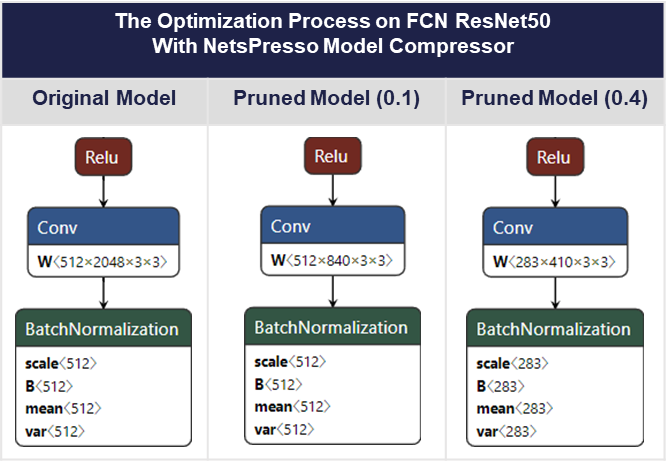
</div>
<div align='center'>Fig. 3 The optimization process for a single convolutional neural network in YOLOv7 with NetsPresso Model Compressor</div>

<a name="Architecture-of-the-compressed-model"></a>

### Architecture of the compressed model

In [ ]:
import torch
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
compressed_model = torch.load('yolov7_voc_compressed_model_L2Norm_02_rep.pt').to(device)

summary(compressed_model.to(device),(3,640,640),device=device)

<a name="Accuracy-comparision"></a>
### Accuracy comparision

Evaluation code for the original model

In [38]:
! python test.py \
--data data/voc.yaml \
--img 640 \
--batch 32 \
--conf 0.001 \
--iou 0.65 \
--device 3 \
--name yolov7_640_val \
--weights yolov7_voc.pt

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='data/voc.yaml', device='3', exist_ok=False, img_size=640, iou_thres=0.65, name='yolov7_640_val', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='val', v5_metric=False, verbose=False, weights=['yolov7_voc.pt'])
YOLOR 🚀 v0.1-117-g8e9f0b7 torch 1.13.1+cu117 CUDA:3 (NVIDIA GeForce RTX 3090, 24268.3125MB)

Traceback (most recent call last):
  File "test.py", line 319, in <module>
    test(opt.data,
  File "test.py", line 58, in test
    model = attempt_load(weights, map_location=device)  # load FP32 model
  File "/root/workspace/projects/project_yolov7/best_practice/yolov7/models/experimental.py", line 253, in attempt_load
    model.append(ckpt['ema' if ckpt.get('ema') else 'model'].float().fuse().eval())  # FP32 model
  File "/opt/conda/envs/yolov7_bp/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1269, in __getattr__
    raise Att

Evaluation code for the compressed model

In [ ]:
! python test_npmc.py \
--data data/voc.yaml \
--img 640 \
--batch 32 \
--conf 0.001 \
--iou 0.65 \
--device 3 \
--name yolov7_640_val \
--cfg /root/workspace/YOLOv7_bestPractice/yolov7/cfg/training/yolov7-voc.yaml \
--graphmodule_model yolov7_voc_compressed_model_L2Norm_02_rep.pt \
--no-trace

<a name="FLOPs-&-Parameters-comparision"></a>
### FLOPs & Parameters comparision

In [ ]:
from thop import profile

device = 'cuda' if torch.cuda.is_available() else 'cpu'

original_model = torch.load('yolov7_voc.pt', map_location='cpu').to(device)
compressed_model = torch.load('yolov7_voc_compressed_model_L2Norm_02_rep.pt', map_location='cpu').to(device)

dummy_input = torch.ones((1,3,640,640)).to(device)

original_macs, original_params = profile(original_model, inputs=(dummy_input, ))
compressed_macs, compressed_params = profile(compressed_model, inputs=(dummy_input, ))

print("\n--- Original model ==> Compressed model ---")
print(f"FLOPs: {original_macs*2} ==> {compressed_macs*2} (x{round(original_macs/compressed_macs,3)})")
print(f"Params: {original_params} ==> {compressed_params} (x{round(original_params/compressed_params,3)})")

### Latency comparision

In [ ]:
import onnx
import torch
def onnxExport(model, model_name, device = torch.device('cpu')):
    model = model.to(device.type)
    dummy_input = torch.ones((1,3,640,640)).to(device.type)
    torch.onnx.export(model,dummy_input,model_name,verbose=False)

original_model = torch.load('yolov7_voc.pt', map_location='cpu')
compressed_model = torch.load('yolov7_voc_compressed_model_L2Norm_02_rep.pt', map_location='cpu')

onnxExport(original_model, 'yolov7_voc.onnx')
onnxExport(compressed_model, 'yolov7_voc_compressed_model_L2Norm_02_rep.onnx')

In [ ]:
import onnxruntime
import numpy as np

def inference_time(model_path,run_times):
    device = torch.device('cpu')
    img_size = 640
    so = onnxruntime.SessionOptions()
    so.execution_mode = onnxruntime.ExecutionMode.ORT_SEQUENTIAL
    so.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
    exproviders = [ 'CPUExecutionProvider']
    ort_session = onnxruntime.InferenceSession(model_path, so, providers=exproviders)

    input_names = ort_session.get_inputs()[0].name
    output_names = ort_session.get_outputs()[0].name
    # warm up
    dummy_input = np.random.rand(1,3,img_size,img_size).astype(np.float32)
    for _ in range(10):
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding = ort_session.io_binding()
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        torch.cuda.synchronize()

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    latency = []
    for _ in range(run_times):
        dummy_input = np.random.rand(1,3,img_size,img_size).astype(np.float32)
        #IOBinding
        data = onnxruntime.OrtValue.ortvalue_from_numpy(dummy_input, device.type, 0)
        io_binding.bind_input(input_names, device.type, 0, np.float32, [1, 3, img_size, img_size], data.data_ptr())
        io_binding.bind_output(output_names, device.type)

        torch.cuda.synchronize()
        start.record() 
        with torch.no_grad():
            ort_session.run_with_iobinding(io_binding)
        end.record()
        torch.cuda.synchronize()
        time_elapsed = start.elapsed_time(end)
        latency.append(time_elapsed)
    return sum(latency)/len(latency)


original_latency = inference_time('yolov7_voc.onnx',run_times=10)
compressed_latency = inference_time('yolov7_voc_compressed_model_L2Norm_02_rep.onnx',run_times=10)

print("Original Model ==> Compressed Model")
print(f"Latency: {round(original_latency,3)}ms ==> {round(compressed_latency,3)}ms (x{round(original_latency/compressed_latency,3)})")

# Appendix 1. Transfer Learning on PASCAL VOC
In this section, we provide the details of how to get PASCAL VOC pretrained YOLOv7.

### Transfer Learning

To do transfer learning the COCO pretrained YOLOv7 model on PASCAL VOC, we need YAML files for fine-tuning the model on PASCAL VOC.
- Please run this [code block](#-Preparing-YAML-files-for-fine-tuning-the-model-on-PASCAL-VOC) to prepare the YAML files.

Downloading COCO pretrained YOLOv7

In [ ]:
! wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

### Transfer Learning

In [ ]:
! python -m torch.distributed.launch --nproc_per_node 4 --master_port 9999 train.py \
--workers 8 \
--device 0,1,2,3 \
--sync-bn \
--batch-size 64 \
--data data/voc.yaml \
--img 640 640 \
--cfg cfg/training/yolov7-voc.yaml \
--weights 'yolov7_training.pt' \
--name yolov7_voc \
--hyp data/hyp.scratch.p5-voc.yaml \
--epochs 50

### Conversion into GraphModule format

To convert the YOLOv7 into GraphModule format, we need to fix the flow of the model because `torch.fx` doen't support dynamic control flow now ([link](https://pytorch.org/docs/stable/fx.html#limitations-of-symbolic-tracing)). You can download the fixed model by running the following code block.

In [ ]:
! cd models && \
wget https://raw.githubusercontent.com/Nota-NetsPresso/NetsPresso-Model-Compressor-ModelZoo/main/best_practices/object_detection/torch/yolov7_voc/yolo_npmc.py

Conversion into GraphModule format

You may need to fix the path to your model. Here, we set the default as `/runs/train/yolov7_voc/weights/best.pt`.

In [ ]:
from models.experimental import attempt_load
from utils.torch_utils import intersect_dicts
from models.yolo_npmc import Model
import torch
device = 'cpu'

model = torch.load('/runs/train/yolov7_voc/weights/best.pt')['model'].float().train() # modify the path to your model
graph = torch.fx.Tracer().trace(model)
traced_model = torch.fx.GraphModule(model, graph)
    
torch.save(traced_model, 'yolov7_voc.pt')

<a name="#appendix-2-description-of-the-modifications"></a>
# Appendix 2. Description of The Modifications
In this section, we go into detail about the code we've changed for the compression.

### For exporting

* `yolo_npmc.py`
  * As mentioned [above](), we need to fix the flow of the model to covert the model into GraphModule format. We fixed the flow as training mode. ([link 1]()), ([link 2]()).
  * After training the compressed model, the postprocessing function `post_processing` is required for the model ([link]()). This process was originally defined in the `forward` function of the inference mode ([link]()).


### For Training

* `train_npmc.py`
  * The model's attributes are likely to be changed when we convert the model into a GraphModule format. Here, we change how to access the GraphModule model's parameters. ([link 1]()), ([link 2]()).
  * To use the hyper-parameter settings, we create `cfg_model` that contains the configurations same as the model to be trained. ([link 1]()), ([link 2]()), ([link 3]()), ([link 4]()).
  * `test_npmc` is used to test the compressed model ([link]()). 
  * To train the GraphModule model, we add argparser ([link]()) to load the model ([link]()).
* `test_npmc.py`
  * Similar to `train_npmc`, `cfg_model` is used for the hyper-parameter settings ([link 1]()), ([link 2]()), ([link 3]()), ([link 4]()).
  * We attach the `post_processing` to the compressed model for testing ([link]()).  
  * We add argument `--pt_model` and `--cfg` to get the GraphModule model and the directory for the model's configuration file ([link]()).

### For Reparameterization
* `reparameterization_npmc.py`
  * To merge `BN` layers to `conv` layers, merge YOLOR to `conv` and reparameterize `RepConv` layers, reparameterization process is required. We define new function `reparameterization_npmc.py` to reparameterize the GraphModule model ([link]()). You can check the original codes from [here]().